# Value at Risk - Methodologies Comparison



The purpose of this notebook is to compare different methologies of Value at Risk (VaR).

Value at Risk is, in simple terms, the maximum expected loss of a portfolio given a confidence level during an specific period of time.

VaR is specially important for financial institutions that hold positions in multiple securities. VaR allows these institutions to asses what would be their loss in case there adverse movement in the market that could affect the value of their positions.

In addition, regulators require that financial instiutions hold certain capital levels based on the positions they hold in the market. For example, Basel regulations include VaR in some of its calculations to stablish= the amount a financial institution should hold in their bauls.

Thus, VaR and its different methodologies are worth exploring.

In the current notebook three main VaR Methologies are assesed:

1. Historial Simulation
2. Risk Metrics
3. Garch
4. Filtered Historical Simulation

Each methodology will be explained shortly.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import statsmodels.api as sm
from scipy import stats
import datetime as dt
import pylab as py

In [3]:
!pip3 install arch
from arch import arch_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.4 MB/s eta 0:00:00


The Data Extraction class efficiently extracts data for specific stocks or indices. Besides downloading data from Yahoo Finance, it also calculates key metrics such as variance, returns, and their annualized versions.

Additional methods are included to assess the non-normality of returns. Notably, a Quantile-Quantile (Q-Q) Plot is added: if the returns do not lie on the 45-degree line, it indicates that the returns have fatter or thinner tails than a normal distribution.

Lastly, the Data Extraction class calculates the autocorrelation of returns. Typically, daily returns exhibit low levels of autocorrelation, indicating that past returns cannot be used to predict future returns.

In [39]:
# NOTE: PARENT CLASS
class data_extraction:
    start_date = dt.date.today() - dt.timedelta(4000)
    end_date = dt.date.today()
    interval = '1d'

    def __init__(self, tickers, window=500):
        self.window = window
        self.prices = pd.DataFrame()
        self.tickers = tickers
        for ticker in self.tickers:
            self.ticker = ticker
            self.prices[ticker] = yf.download(ticker,start = self.start_date, end = self.end_date, interval=self.interval)['Adj Close']
            self.returns = np.log(self.prices / self.prices.shift(1))[1:]

    def main_metrics(self):
        # Return
        self.avg_daily_returns = self.returns.mean()
        self.ann_return = self.avg_daily_returns * 252
        # Variance
        self.vol = self.returns.std()
        self.ann_vol= self.vol * np.sqrt(252)
        # Coefficient Variation
        self.cv_annual = self.ann_vol / self.ann_return
        self.metrics = pd.DataFrame()
        self.metrics['Annual Return'] = self.ann_return
        self.metrics['Annual Volatility'] = self.ann_vol
        self.metrics['Coefficient of Variation'] = self.cv_annual

    def main_metrics_show(self):
        self.main_metrics()
        return self.metrics

    # QQ PLOT TO REVIEW THE NON-NORMALITY OF THE STOCKS/INDEX
    def qq_plot(self,ticker):
        self.ticker = ticker
        sm.qqplot(self.returns[self.ticker],line='q')
        plt.show()

    # AUTOCORRELATION OF THE RETURNS OF THE STOCK/INDEX
    def autocorr(self,ticker):
        self.ticker = ticker
        pd.plotting.autocorrelation_plot(self.returns[self.ticker]).set_xlim([0, 20])
        plt.show()

## Methodology 1: Historical Simulation

The Historical Simulation (HS) is relatively simple: consider the fact that the financial institution counts with the availability of past m daily returns, calculated using past prices of the underlying asset of the portfolio, but using today today's portfolio weights.  

The HS technique simply assumes that the distribution of tomorrow's portfolio returns is well approximated by the empirical distribution of the past m observations.  The VaR with a coverage rate, p, is simply calculated as percentile of the sequence of past returns.

In [5]:
# Historical Simulation Class
class historical_var(data_extraction):
    # The default window for Historical simulation is 500
    def __init__(self, tickers,window = 500):
        super().__init__(tickers, window)
        self.window = window
        self.pace = len(self.returns)
        # Variable where the quantiles will be storaged
        self.var_hs = np.zeros(len(self.returns))
        for ret in range(self.window,self.pace):
            # Using the 99% Quantile
            self.var_hs[ret] = -(self.returns[self.ticker].iloc[ret-window:ret].quantile(0.01,interpolation = 'linear'))
        self.hist_sim=self.var_hs[self.window:]

In [6]:
# Historical Simulation
sp500_hs = historical_var(['^GSPC'])

[*********************100%%**********************]  1 of 1 completed


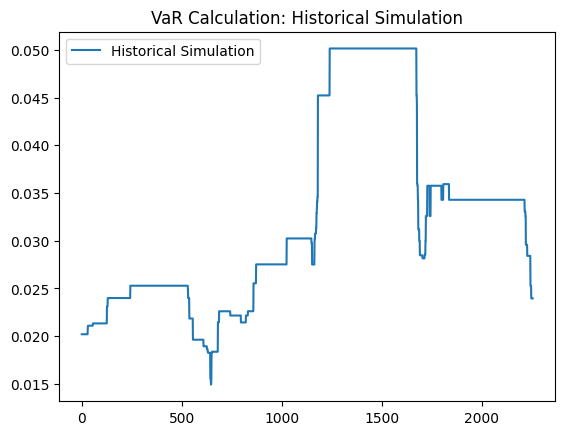

In [7]:
plt.plot(sp500_hs.hist_sim, label = 'Historical Simulation')
plt.legend(loc = 'upper left')
plt.title('VaR Calculation: Historical Simulation')
plt.show()

The most obvious advantage of the HS method is its ease of implementation. Being model-free, it does not rely on any specific assumptions about the distribution of returns. Instead, it directly uses historical return data, which allows it to naturally account for tail risks associated with the portfolio's returns.

On the opposite side, the cons of the Historical Simulation (HS) method include the uncertainty in determining the appropriate length of the historical window used to construct the histogram. The chosen window might either include or exclude events that could or could not happen in the future, potentially skewing the results. Additionally, the lack of properly specified dynamics in the HS methodology causes it to overlook well-established stylized facts about return dependence, such as variance clustering. Since the HS method does not rely on a well-specified dynamic model, there is no theoretically correct way to extrapolate from the 1-day distribution to the 10-day distribution.

## Methodology 2: Risk Metrics

The Risk Metrics (RM) model can pick up the increase in market variance from the crash regardless of whether the crash meant a gain or a loss.

In this model,returns are squared and losses and gains are treated as having the same impact on tomorrow’s variance and therefore on the portfolio risk.

In the case of the risk metrics model, the variance dynamics is driven by:

$$ \sigma_{\text{pf},t+1}^2 = 0.94 \sigma_{\text{pf},t}^2 + 0.06 R_{\text{pf},t}^2 $$

and the VaR would be calculated as:

$$ \text{VaR}_{\text{pf},t+1} = -\sigma_{\text{pf},t+1} \cdot N^{-1} $$

In [8]:
# Risk Metrics Model Class
class risk_metrics(data_extraction):
    def __init__(self, tickers):
        super().__init__(tickers)
        self.main_metrics()
        self.lamb = 0.94
        # Variance
        self.variance_rm = np.zeros(len(self.returns))
        self.variance_rm[0] = (self.vol ** 2)  #The first value of the variance is defined as the variance of the stock // Index sample
        self.var_rm = np.zeros(len(self.returns))
        self.var_rm[0] = -stats.norm.ppf(0.01) * np.sqrt(self.variance_rm[0])
        for index in range(1,len(self.returns)):
            self.variance_rm[index] = self.lamb * self.variance_rm[index - 1] + ((self.returns.iloc[index - 1]) ** 2) * (1-self.lamb)
            self.var_rm[index] = -stats.norm.ppf(0.01) * (np.sqrt(self.variance_rm[index]))
        self.var_risk_metrics = self.var_rm[self.window:]

In [10]:
# Risk Metrics
sp500_rm = risk_metrics(['^GSPC'])

[*********************100%%**********************]  1 of 1 completed
<ipython-input-8-37761bf6d39d>:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.variance_rm[0] = (self.vol ** 2)  #The first value of the variance is defined as the variance of the stock // Index sample
<ipython-input-8-37761bf6d39d>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.variance_rm[index] = self.lamb * self.variance_rm[index - 1] + ((self.returns.iloc[index - 1]) ** 2) * (1-self.lamb)


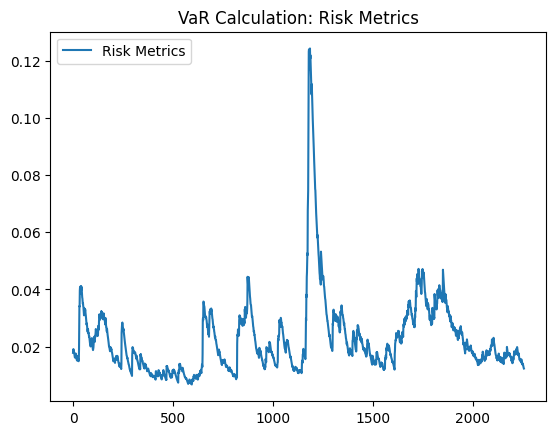

In [11]:
# Risk Metrics
plt.plot(sp500_rm.var_risk_metrics, label = 'Risk Metrics')
plt.legend(loc = 'upper left')
plt.title('VaR Calculation: Risk Metrics')
plt.show()

## Methodology 3: Garch Model

The Generalized Autoregressive Conditional Hetroskedasticity (GARCH) can capture important features of returns data and are flexible enough to accommodate specific aspects of individual assets.

The downside of the model is that it requires nonlinear parameter estimation.

The simplest GARCH model of dynamic variance can be written as:

$$ \sigma_{t+1}^2 = \omega + \alpha \varepsilon_{t}^2 + \beta \sigma_{t}^2 $$
     

Again, the VaR would be calculated as follows:

$$ \text{VaR}_{\text{pf},t+1} = -\sigma_{\text{pf},t+1} \cdot N^{-1} $$

In [52]:
# Garch Model Class
class garch_model(data_extraction):
    def __init__(self, tickers, window=500):
        super().__init__(tickers, window)
        self.var_garch = np.zeros(len(self.returns))
        self.var_fhs = np.zeros(len(self.returns))
        self.window = window
        for ret in range(self.window,len(self.returns)):
            self.ret_window = self.returns.iloc[ret-500:ret]
            self.garch_model = arch_model(self.ret_window,p = 1, q = 1, mean ='Zero', vol = 'GARCH', dist='normal', rescale=False).fit(update_freq=0,disp=False)
            self.omega = self.garch_model.params.iloc[0]
            self.alpha = self.garch_model.params.iloc[1]
            self.beta = self.garch_model.params.iloc[2]
            self.sigma = self.garch_model.conditional_volatility.values
            self.sigmapred = np.sqrt(((self.omega + self.alpha * (self.ret_window.iloc[-1]**2) + self.beta * (self.sigma[-1]**2))).values)
            self.var_garch[ret] = -stats.norm.ppf(0.01) * self.sigmapred[0]
            # Filtered Historical Simulation
            self.std_resid = self.garch_model.std_resid
            self.var_fhs[ret] = -(self.std_resid.quantile(0.01,interpolation = 'linear')) * self.sigmapred[0]

    def show_garch(self):
        return self.var_garch[self.window:]

    def show_garch_fhs(self):
        return self.var_fhs[self.window:]



In [53]:
# Garch Model
sp500 = garch_model(['^GSPC'])
sp500_garch_var = sp500.show_garch()

[*********************100%%**********************]  1 of 1 completed


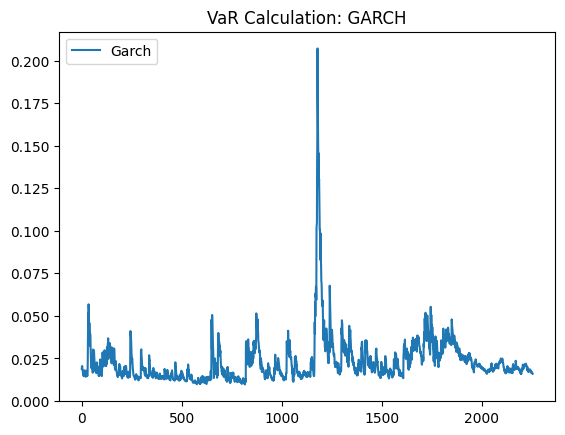

In [54]:
plt.plot(sp500_garch_var, label = 'Garch')
plt.legend(loc = 'upper left')
plt.title('VaR Calculation: GARCH')
plt.show()

An advantage of the GARCH model over the RM approach is that the long run variance is defined in the former:

$$ \sigma^2 = \frac{\omega}{1 - \alpha - \beta} $$

Thus an important quirk of the RM model is that it ignores the fact that the long-run average variance tends to be relative stable over time.
The GARCH model implicitly relies on

$$ \sigma$$

## Methodology 4: Filtered Historical Simulation

A caviat about that both, the RM and the GARCH models shared is that, both of them are asuuming that the returns follow a normal distribution, something that does not fit what it is observed in the real world.

To further test this assumption, it is possible to look at the QQ-Plot of the returns.

In [55]:
sp500_qq = data_extraction(['^GSPC'])

[*********************100%%**********************]  1 of 1 completed


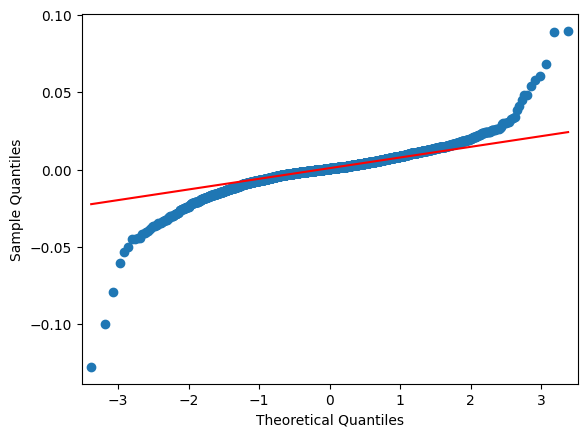

In [56]:
sp500_qq.qq_plot('^GSPC')

As shown in the graphic above, the returns have fatter tails than the normal distribution.

The Filtered Historical Simulation(FHS) attempts to combine the best of the model-based with the best of the model-free approaches in a very intuitive fashion.

Assume the GARCH model has been estimated for the portfolio variance.

Given a sequence of past returns, it is calculated the standardized returns:

$$ r^{std}_{t+1} = \frac{r_t}{\sigma^{garch}_t} $$

To calculate the VaR, then it is used:

$$ \text{VaR}_{\text{pf},t+1} = -\sigma_{\text{pf},t+1} Percentile(r^{std}_{t+1}) $$



In [57]:
sp500_fhs_var = sp500.show_garch_fhs()

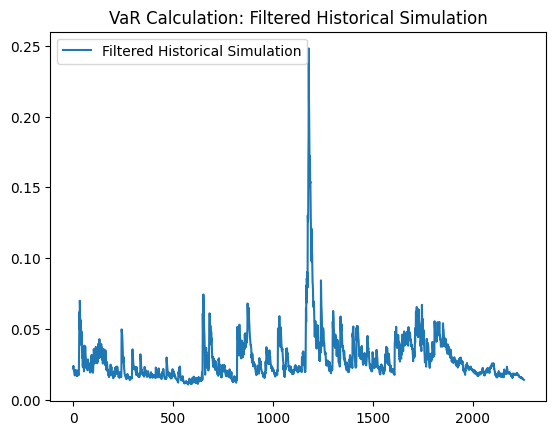

In [58]:
plt.plot(sp500_fhs_var, label = 'Filtered Historical Simulation')
plt.legend(loc = 'upper left')
plt.title('VaR Calculation: Filtered Historical Simulation')
plt.show()

# Comparison of the 4 methodologies

In order to compare all the methodologies, all the series are plotted in a single graph:

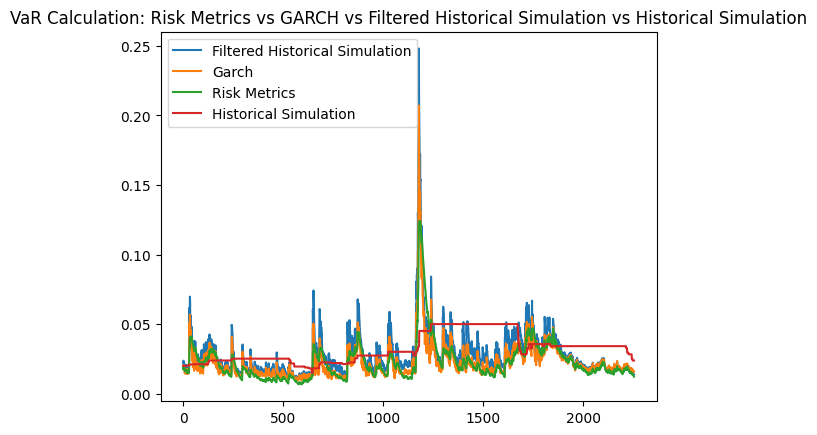

In [59]:
# Graphs
# Garch Model
plt.plot(sp500_fhs_var, label = 'Filtered Historical Simulation')
plt.plot(sp500_garch_var, label = 'Garch')
# Risk Metrics
plt.plot(sp500_rm.var_risk_metrics, label = 'Risk Metrics')
# Historical Simulation
plt.plot(sp500_hs.hist_sim, label = 'Historical Simulation')
plt.legend(loc = 'upper left')
plt.title('VaR Calculation: Risk Metrics vs GARCH vs Filtered Historical Simulation vs Historical Simulation')
plt.show()


From the graph we can conclude the following:


1. Although the Historical Simulation (HS) method is easy to estimate, it fails to capture rapid increases in market volatility. Additionally, when the market returns to "normal" conditions, the HS method does not adjust quickly, potentially leading financial institutions to be overly cautious after volatility subsides.

2. The GARCH, Filtered Historical Simulation (FHS), and RiskMetrics (RM) models effectively captured the volatility spike in March 2020. Due to their mathematical foundations, both the GARCH and FHS models are particularly adept at capturing the tail risk associated with the market.

3. Among these, the FHS model appears to be the most effective at capturing tail risk during the reviewed period.

